# Backtesting Value at Risk with Python

<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<br>__[Practical Econometrics with Python](https://www.amazon.com/-/es/Marlon-Saito-ebook/dp/B08KJ1322G/ref=sr_1_1?dchild=1&qid=1603904149&refinements=p_27%3AMarlon+Saito&s=digital-text&sr=1-1&text=Marlon+Saito)__ 
<br>__[Econometría Práctica con Python](https://www.amazon.com/-/es/Marlon-Saito-ebook/dp/B08KHZKV9R/ref=sr_1_2?dchild=1&qid=1603903646&refinements=p_27%3AMarlon+Saito&s=digital-text&sr=1-2&text=Marlon+Saito)__ 
<br>__[Riskfolio-Lib](https://github.com/dcajasn/Riskfolio-Lib)__ 

<br>Hi people, en este post trataré diferentes metodologías para realizar el backtesting del Value at Risk asi que espero les guste :D.

Para Python les recomiendo que usen __[winpython](https://winpython.github.io/)__ (solo windows, pero es portable)  o __[anaconda](https://www.anaconda.com/download/)__ (es multiplataforma, pero requiere de instalación). Al instalar cualquiera de estas distribuciones encontraran los ejecutables Jupyter Notebook (el formato del post, los archivos tienen extensión es .ipynb) y Spyder (IDE que recomiendo para trabajar porque permite visualizar las variables y su tipo, los archivos tienen extensión es .py)

En la página del blog dejaré los notebooks (se abren con jupyter notebook), los scripts de python (recomiendo que usen spyder para trabajar con estos archivos) y los archivos en excel con la data usada en los ejemplos.
<br>Los temas que trataremos en este post son:

1. Backtesting Historical VaR, CVaR, EVaR and RLVaR

## 1 Backtesting Normal VaR, CVaR, EVaR and RLVaR 

### 1.1 Downloading Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf
import riskfolio as rp
import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2016-01-01'
end = '2022-12-30'

# List of assets
assets = ['CMG', 'TSLA']
assets.sort()

# Downloading the data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
data = data/data.iloc[0,:] * 1000000
ret = data.diff().dropna()

display(ret.head())

[*********************100%***********************]  2 of 2 completed


,CMG,TSLA
Date,,
2016-01-05,490.187879,89.515019
2016-01-06,-49820.604428,-19649.955297
2016-01-07,-23774.010129,-15173.884205
2016-01-08,-6038.170874,-20813.778602
2016-01-11,-4879.575886,-14099.639949


## 1 Backtesting Historical VaR, CVaR, EVaR and RLVaR

### 1.1 Calculating Historical VaR, CVaR, EVaR and RLVaR.

In [2]:
n = ret.shape[0]

Risk_hist = {}
for i in assets:
    Risk_hist[i] = {'VaR':[], 'CVaR': [], 'EVaR': [], 'RLVaR': []}

window = 252 * 1
alpha = 0.05
k = 0
for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        Risk_hist[j]['VaR'].append(-rp.VaR_Hist(X, alpha=alpha))
        Risk_hist[j]['CVaR'].append(-rp.CVaR_Hist(X, alpha=alpha))
        try:
            Risk_hist[j]['EVaR'].append(-rp.RLVaR_Hist(X, alpha=alpha, kappa=0.01, solver='MOSEK'))
        except:
            Risk_hist[j]['EVaR'].append(Risk_hist[j]['EVaR'][-1])
        #Risk_hist[j]['EVaR'].append(-rp.EVaR_Hist(X, alpha=alpha)[0])
        try:
            Risk_hist[j]['RLVaR'].append(-rp.RLVaR_Hist(X, alpha=alpha, kappa=0.3, solver='MOSEK'))
        except:
            Risk_hist[j]['RLVaR'].append(Risk_hist[j]['RLVaR'][-1])

        
for i in assets:
    Risk_hist[i] = pd.DataFrame(Risk_hist[i], index=ret.index[window:])

### 1.2 Plotting Historical VaR, CVaR EVaR and RLVaR.

[]

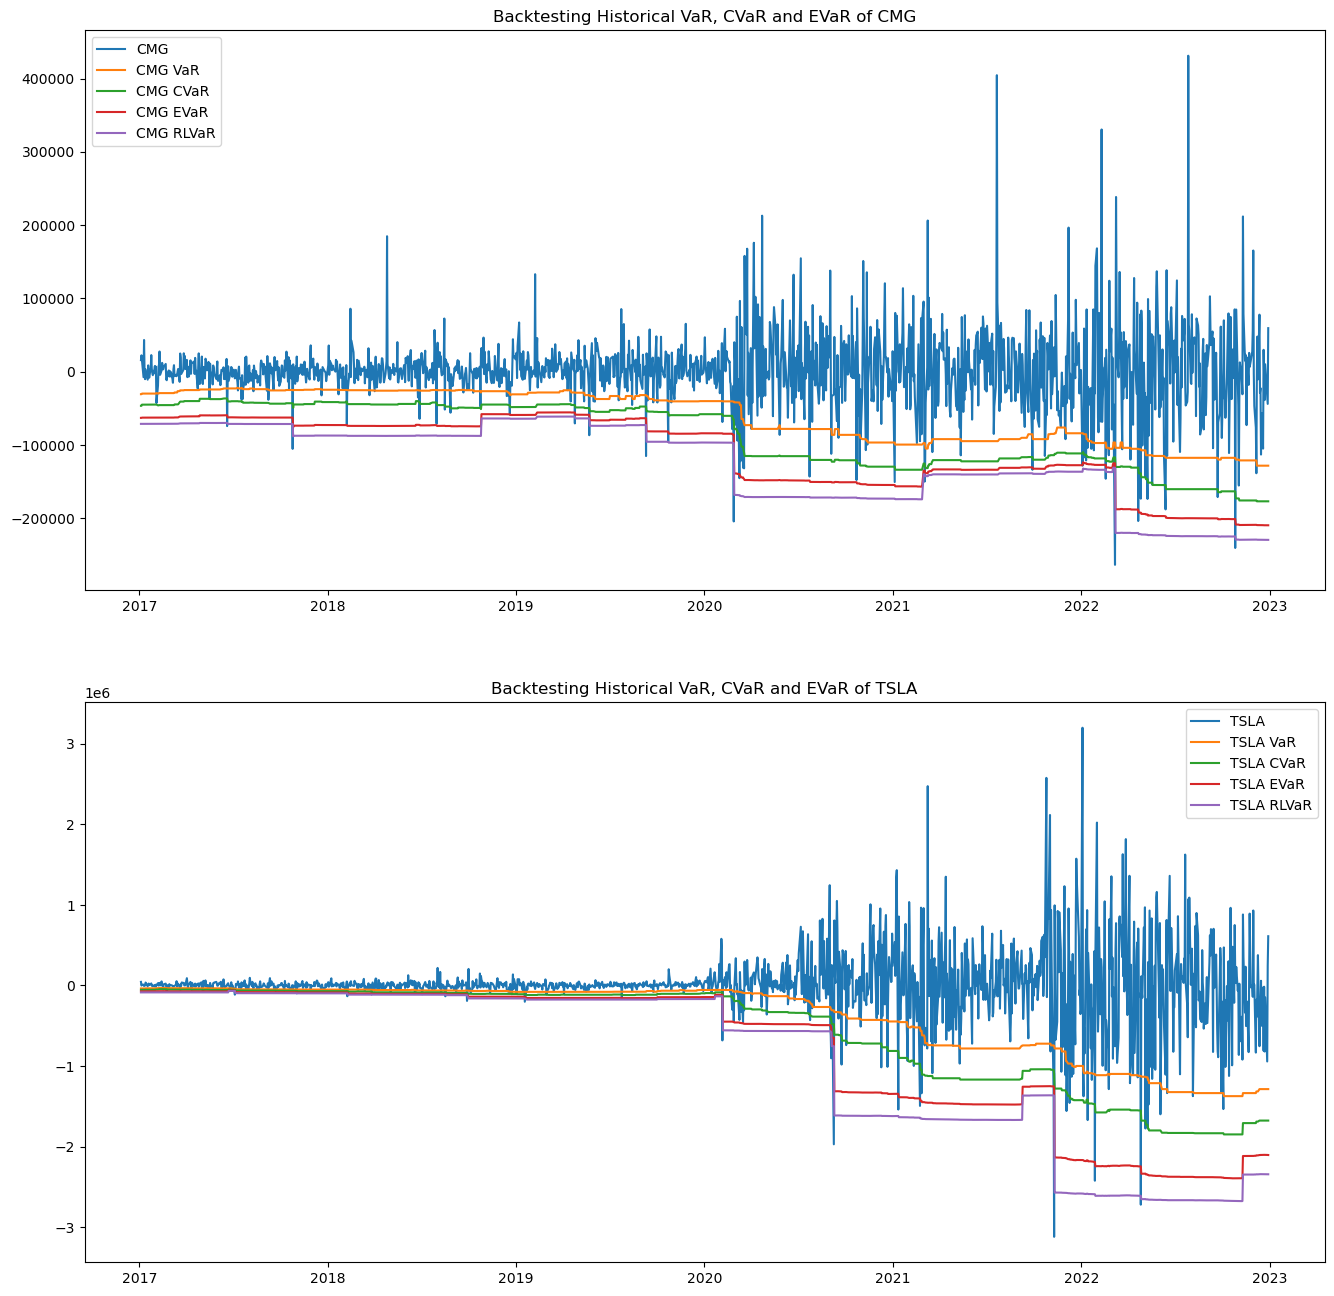

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_hist[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_hist[assets[i]]['CVaR'], label=assets[i] + ' CVaR')
    ax[i].plot(Risk_hist[assets[i]]['EVaR'], label=assets[i] + ' EVaR')
    ax[i].plot(Risk_hist[assets[i]]['RLVaR'], label=assets[i] + ' RLVaR')
    ax[i].legend()
    ax[i].set_title('Backtesting Historical VaR, CVaR and EVaR of ' + assets[i])

plt.plot()

### 1.3 Making Formal Tests to Evaluate VaR Models:

Vamos a utilizar dos test para evaluar la calidad de los modelos VaR:

__El test de Kupiec (1995)__ o coverage test o Bernoulli test. Pueden encontrar la teoria en este __[link](https://www.value-at-risk.net/backtesting-coverage-tests/)__

__El test de Christofferson (1998)__ o independente test. Pueden encontrar la teoria en este __[link](https://www.value-at-risk.net/backtesting-independence-tests/)__

In [4]:
def bern_test(p,v):
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    return (-2*(al-bl))

def ind_test(V):
    T = len(V)
    J = np.full([T,4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.nan_to_num(np.log(p_00), -60)*V_00 + np.nan_to_num(np.log(p_01), -60)*V_01
    bl += np.nan_to_num(np.log(p_10)*V_10, -60) + np.nan_to_num(np.log(p_11), -60)*V_11
    return (-2*(al-bl))

In [6]:
keys = ['Failure Ratio VaR', 
        'Failure Ratio CVaR',
        'Failure Ratio EVaR',
        'Failure Ratio RLVaR',
        'Bernoulli Test VaR stat',
        'Bernoulli Test VaR p-value',
        'Bernoulli Test CVaR stat',
        'Bernoulli Test CVaR p-value',
        'Bernoulli Test EVaR stat',
        'Bernoulli Test EVaR p-value',
        'Bernoulli Test RLVaR stat',
        'Bernoulli Test RLVaR p-value',
        'Independent Test VaR stat',
        'Independent Test VaR p-value',
        'Independent Test CVaR stat',
        'Independent Test CVaR p-value',
        'Independent Test EVaR stat',
        'Independent Test EVaR p-value',
        'Independent Test RLVaR stat',
        'Independent Test RLVaR p-value',
       ]

Stats_hist = {}
    
for i in assets:
    Stats_hist[i] = {}
    for j in keys:
        Stats_hist[i][j] = []

for i in Stats_hist.keys():
    for j in Risk_hist[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_hist[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_hist[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        print(i, H, T)
        Stats_hist[i]['Failure Ratio ' + j].append(H/T)
        Stats_hist[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_hist[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_hist[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_hist[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_hist[i] = pd.DataFrame(Stats_hist[i]).T
    Stats_hist[i].columns = [i]
    a = pd.concat([a, Stats_hist[i]], axis=1)

Stats_hist = a
display(Stats_hist)

CMG 98 1508
CMG 40 1508
CMG 16 1508
CMG 10 1508
TSLA 126 1508
TSLA 50 1508
TSLA 23 1508
TSLA 13 1508


,CMG,TSLA
Failure Ratio VaR,0.064987,0.083554
Failure Ratio CVaR,0.026525,0.033156
Failure Ratio EVaR,0.010610,0.015252
Failure Ratio RLVaR,0.006631,0.008621
Bernoulli Test VaR stat,6.541820,30.004240
Bernoulli Test VaR p-value,0.010540,0.000000
Bernoulli Test CVaR stat,20.953400,10.169280
Bernoulli Test CVaR p-value,0.000000,0.001430
Bernoulli Test EVaR stat,71.622560,52.077280
Bernoulli Test EVaR p-value,0.000000,0.000000


Se puede observar que los modelos EVaR y RLVaR tienen los menores failure ratios. En el caso del test de Bernoulli, el CVaR, EVaR y RLVaR pasan el test debido a que la cantidad de perdidas observadas es igual o menor a las esperadas. En el caso del test de indepencia, el CVaR, EVaR y RLVaR no cumplen el test debido a que este test fue diseñado para el VaR y por otra parte, para el CVaR, EVaR y RLVaR hay ventanas o franjas de tiempo en los que no existen perdidas mayores a estas medidas de riego o su número es muy escazo.
 
### 1.4 Conclusions

Se puede observar que los modelos EVaR y RLVar son los mejores para modelar las pérdidas mas extremas de activos con alta volatilidad, ya que presenta la menor failure rate y cumple con el test de Bernoulli.

In [7]:
Risk_hist[assets[0]]['EVaR']

Date
2017-01-04    -63038.068998
2017-01-05    -63034.950704
2017-01-06    -62722.924727
2017-01-09    -62688.044056
2017-01-10    -62689.147666
                  ...      
2022-12-22   -209625.082320
2022-12-23   -209640.525782
2022-12-27   -209640.380408
2022-12-28   -209652.417193
2022-12-29   -209659.126004
Name: EVaR, Length: 1508, dtype: float64